#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.8 2021-07-15

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# turning off scientific notation
#pd.set_option("display.float_format", lambda x: "%.2f" % x)


In [30]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")

In [31]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [33]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.182,0.182
diesel,1,0.182,0.364
gas,526,95.811,96.175
hybrid,14,2.550,98.725
other,7,1.275,100.000


In [34]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,222,40.437,40.437
excellent,139,25.319,65.756
fair,15,2.732,68.488
good,114,20.765,89.253
like new,55,10.018,99.271
new,4,0.729,100.000


In [35]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]

In [36]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
transmission,,,
automatic,507,98.256,98.256
manual,7,1.357,99.613
other,2,0.388,100.001


In [37]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,234,45.349,45.349
SUV,2,0.388,45.737
convertible,7,1.357,47.094
coupe,22,4.264,51.358
pickup,1,0.194,51.552
sedan,249,48.256,99.808
wagon,1,0.194,100.002


In [38]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [39]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2
# new variables
data["gas"] = np.where(data["fuel"] == "gas", 1, 0)    
data["hybrid"] = np.where(data["fuel"] == "hybrid", 1, 0)
data["maybe_electric"] = np.where(data["fuel"] == "other", 1,0)
data['old_car'] = np.where(data['age'] > 10, 1, 0)
data['new_car'] = np.where(data['age'] < 3, 1, 0)
data['manual'] = np.where(data['transmission'] == "manual", 1, 0)


In [40]:
# Frequency tables
# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
area,,
chicago,306,6187.715686
los angeles,210,5560.623810


In [41]:
# focus only on Chicago
data = data.loc[data.area == "los angeles"]

In [42]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
condition,,
Missing,81,5524.666667
excellent,56,4890.303571
good,39,4471.076923
like new,34,8000.117647


In [43]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
drive,,
Missing,135,4911.162963
fwd,73,6738.684932
rwd,2,6400.000000


In [44]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
dealer,,
0,193,5052.958549
1,17,11324.117647


In [45]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,11.980952,12.931241,0.200000,0.047619,0.138095,0.161905,0.266667,0.185714,0.085714
std,5.632240,5.658377,0.400956,0.213468,0.345824,0.369244,0.443273,0.389805,0.280611
min,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,8.354975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,13.180550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.000000,16.450363,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,37.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Linear regressions

In [ ]:
model1 = "price ~ age + agesq"
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + gas + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + gas + hybrid + maybe_electric + old_car + new_car + manual + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + gas * age + hybrid * age + maybe_electric * age + old_car * age + new_car * age + manual * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

Estimate ALL regressions

In [47]:
regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

### Table 13.2 Regression models for predicting used car price

In [49]:
stargazer.Stargazer(regs[:4])

In [50]:
# not using startgazer

import statsmodels.formula.api as smf

results = [smf.ols(eq, data=data).fit() for eq in model_equations]

for i, res in enumerate(results, 1):
    print(f"\nModel {i} Summary:")
    print(res.summary())


Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     365.8
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           1.12e-68
Time:                        04:03:59   Log-Likelihood:                -1885.5
No. Observations:                 210   AIC:                             3777.
Df Residuals:                     207   BIC:                             3787.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.674e+04    518.553  

## Cross validation

In [51]:
k_fold = 10

In [ ]:
model1 = "price ~ age + agesq"
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + gas + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + gas + hybrid + maybe_electric + old_car + new_car + manual + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + gas * age + hybrid * age + maybe_electric * age + old_car * age + new_car * age + manual * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

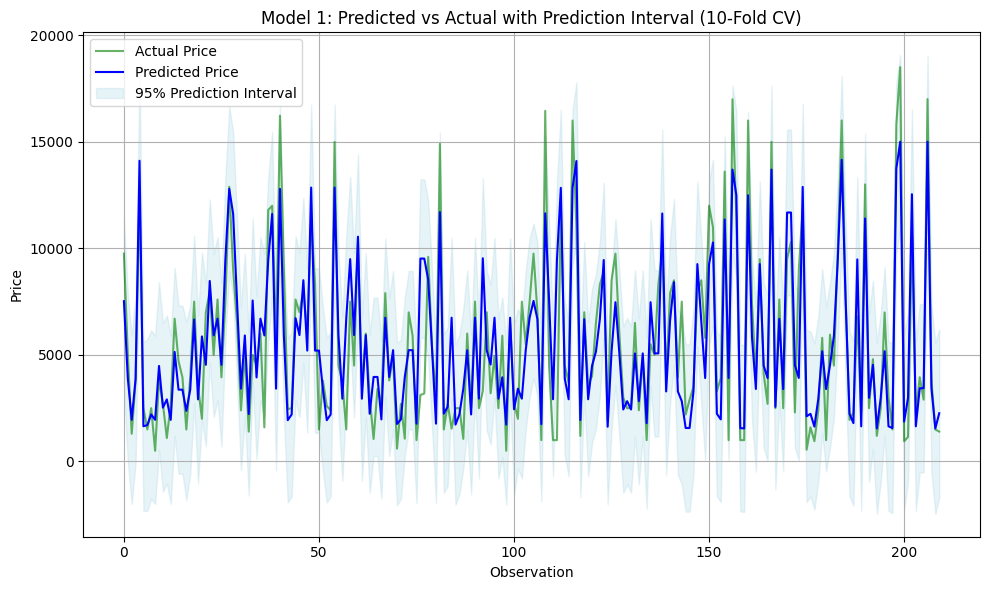

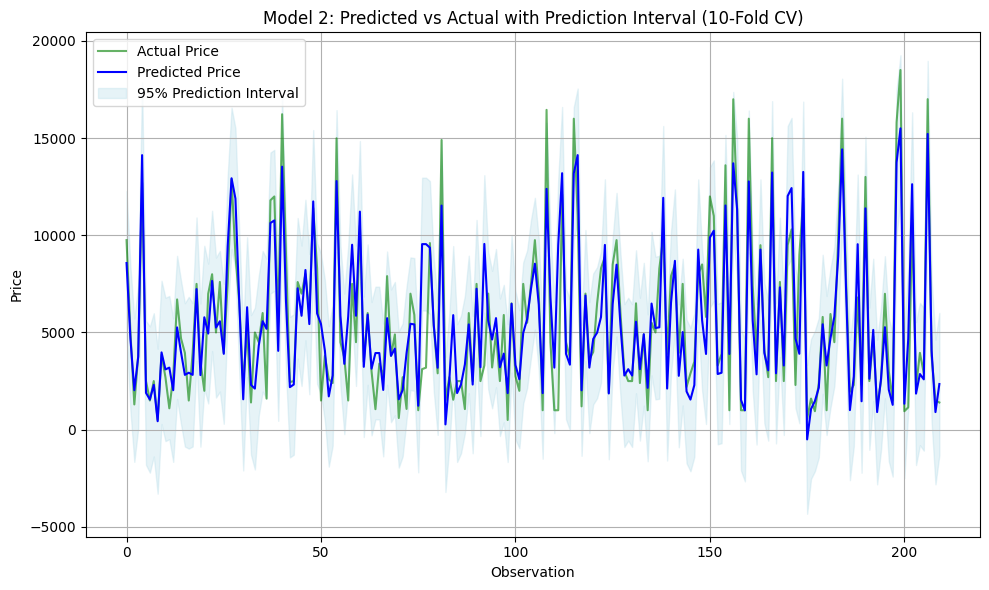

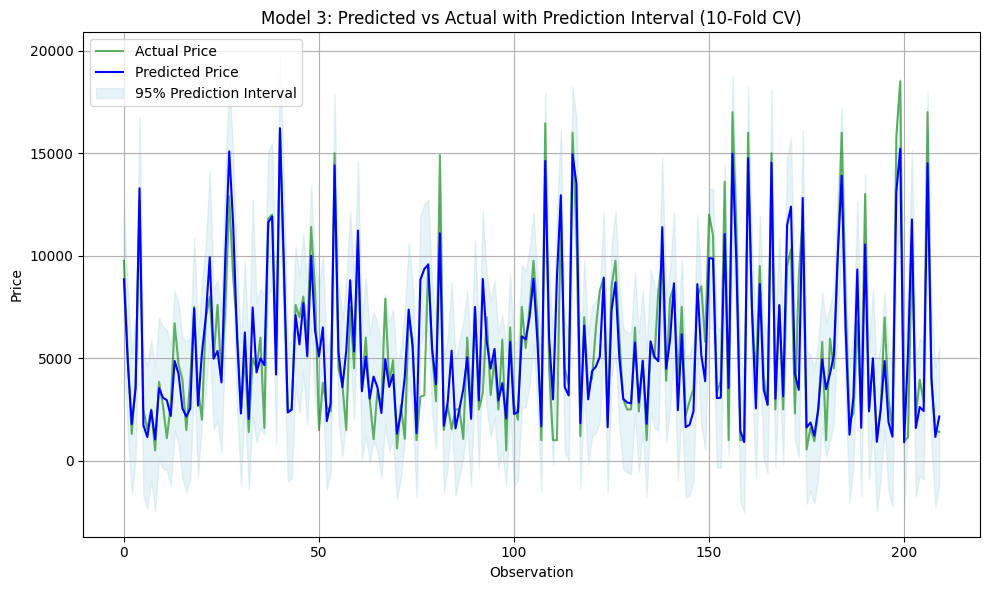

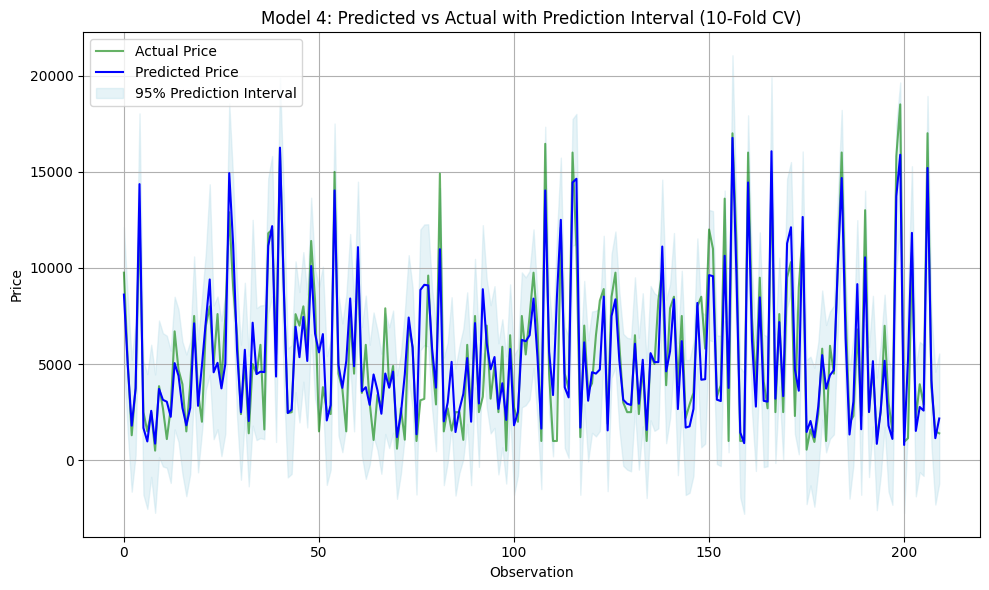

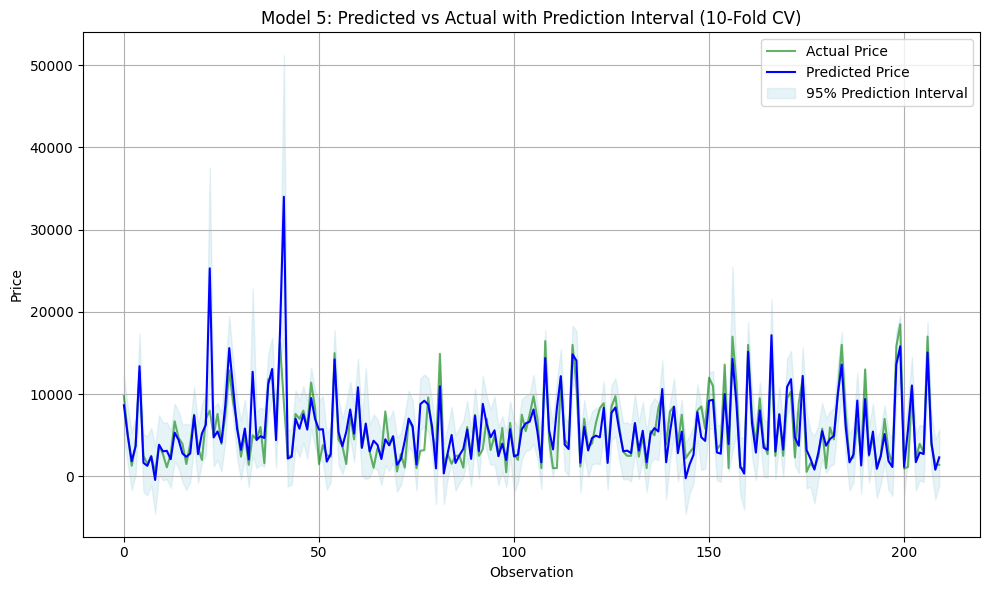

In [52]:
model_equations = [
    "price ~ age + agesq",
    "price ~ age + agesq + odometer",
    "price ~ age + agesq + odometer + odometersq + gas + cond_excellent + cond_good + dealer",
    "price ~ age + agesq + odometer + odometersq + gas + hybrid + maybe_electric + old_car + new_car + manual + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    "price ~ age + agesq + odometer + odometersq + gas * age + hybrid * age + maybe_electric * age + old_car * age + new_car * age + manual * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"
]
# Prepare KFold
kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
results_tables = []


# Loop through models
for i, formula in enumerate(model_equations):
    preds = []
    lowers = []
    uppers = []
    actuals = []
    diff = []

    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        
        model = smf.ols(formula, data=train_data).fit()
        pred_result = model.get_prediction(test_data)
        summary_frame = pred_result.summary_frame(alpha=0.05)  # 95% interval
        
        preds.extend(summary_frame['mean'])
        lowers.extend(summary_frame['obs_ci_lower'])
        uppers.extend(summary_frame['obs_ci_upper'])
        actuals.extend(test_data['price'])
        diff.extend(test_data['price'] - summary_frame['mean'])

    # Plot for this model
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Price', color = 'green', alpha=0.6)
    plt.plot(preds, label='Predicted Price', color='blue')
    plt.fill_between(range(len(preds)), lowers, uppers, color='lightblue', alpha=0.3, label='95% Prediction Interval')
    plt.title(f'Model {i+1}: Predicted vs Actual with Prediction Interval ({k_fold}-Fold CV)')
    plt.xlabel("Observation")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]    
        plt.show()

### Test Set with Predicitions ,Actuals, Diffs and CI Intervals

In [53]:
tables = []
for i, formula in enumerate(model_equations):
    # Fit the model on the whole data (or use your CV split as needed)
    model = smf.ols(formula, data=data).fit()
    pred_result = model.get_prediction(data)
    summary_frame = pred_result.summary_frame(alpha=0.05)
    
    table = pd.DataFrame({
        "Model Name": [f"Model {i+1}"] * len(data),
        "Actual": data["price"].values,
        "Predicted": summary_frame["mean"].values,
        "Diffs": data["price"].values - summary_frame["mean"].values,
        "Lower Bound": summary_frame["obs_ci_lower"].values,
        "Upper Bound": summary_frame["obs_ci_upper"].values,
    })
    table.reset_index(drop=True, inplace=True)
    tables.append(table)

# Display all tables
for table in tables:
    display(table)

,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 1,9750,7532.159575,2217.840425,3707.617498,11356.701652
1,Model 1,2300,1624.247728,675.752272,-2217.283840,5465.779295
2,Model 1,1540,6677.430358,-5137.430358,2853.385179,10501.475537
3,Model 1,9750,7532.159575,2217.840425,3707.617498,11356.701652
4,Model 1,6999,6677.430358,321.569642,2853.385179,10501.475537
...,...,...,...,...,...,...
205,Model 1,1500,2211.690491,-711.690491,-1615.226655,6038.607637
206,Model 1,6800,9439.292496,-2639.292496,5609.509895,13269.075097
207,Model 1,2000,5888.592638,-3888.592638,2064.401971,9712.783306
208,Model 1,2700,2539.287738,160.712262,-1286.443089,6365.018565


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 2,9750,8575.832335,1174.167665,4990.821530,12160.843140
1,Model 2,2300,1484.558284,815.441716,-2098.151820,5067.268388
2,Model 2,1540,5727.894428,-4187.894428,2146.520622,9309.268235
3,Model 2,9750,8575.832335,1174.167665,4990.821530,12160.843140
4,Model 2,6999,6398.275137,600.724863,2830.877059,9965.673215
...,...,...,...,...,...,...
205,Model 2,1500,347.896402,1152.103598,-3279.407029,3975.199833
206,Model 2,6800,9468.126214,-2668.126214,5896.688695,13039.563732
207,Model 2,2000,5799.817047,-3799.817047,2233.474322,9366.159773
208,Model 2,2700,2556.905211,143.094789,-1010.745027,6124.555448


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 3,9750,8857.935164,892.064836,5516.876217,12198.994111
1,Model 3,2300,1675.613602,624.386398,-1657.727778,5008.954982
2,Model 3,1540,5132.700562,-3592.700562,1781.093849,8484.307275
3,Model 3,9750,8857.935164,892.064836,5516.876217,12198.994111
4,Model 3,6999,5716.374945,1282.625055,2406.501480,9026.248411
...,...,...,...,...,...,...
205,Model 3,1500,1657.332923,-157.332923,-1763.090019,5077.755865
206,Model 3,6800,9184.089253,-2384.089253,5854.502298,12513.676208
207,Model 3,2000,5253.285858,-3253.285858,1946.632587,8559.939129
208,Model 3,2700,2717.032758,-17.032758,-599.294092,6033.359607


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 4,9750,8660.216296,1089.783704,5041.994333,12278.438259
1,Model 4,2300,1710.332944,589.667056,-1618.394080,5039.059969
2,Model 4,1540,4853.565794,-3313.565794,1491.440614,8215.690974
3,Model 4,9750,8615.137020,1134.862980,5235.529235,11994.744804
4,Model 4,6999,5311.973044,1687.026956,1976.685019,8647.261070
...,...,...,...,...,...,...
205,Model 4,1500,1560.240502,-60.240502,-1913.319606,5033.800611
206,Model 4,6800,8949.162832,-2149.162832,5619.159820,12279.165845
207,Model 4,2000,4795.789356,-2795.789356,1448.146905,8143.431806
208,Model 4,2700,2880.048196,-180.048196,-431.615158,6191.711550


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 5,9750,8799.783708,950.216292,4884.583364,12714.984053
1,Model 5,2300,1488.482451,811.517549,-1901.480285,4878.445188
2,Model 5,1540,4745.027109,-3205.027109,1354.109401,8135.944817
3,Model 5,9750,8652.114286,1097.885714,5251.073018,12053.155555
4,Model 5,6999,5390.647643,1608.352357,2042.283569,8739.011717
...,...,...,...,...,...,...
205,Model 5,1500,634.504753,865.495247,-3012.733352,4281.742857
206,Model 5,6800,8933.458705,-2133.458705,5539.205901,12327.711509
207,Model 5,2000,5046.028439,-3046.028439,1669.915367,8422.141511
208,Model 5,2700,2772.764499,-72.764499,-551.927517,6097.456516


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = []
for i, formula in enumerate(model_equations):
    model = smf.ols(formula, data=data).fit()
    y_true = data["price"]
    y_pred = model.fittedvalues

    r2 = r2_score(y_true, y_pred)
    bic = model.bic
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics.append({
        "Model": f"Model {i+1}",
        "R2": r2,
        "BIC": bic,
        "RMSE": rmse,
        "MAE": mae
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,Model,R2,BIC,RMSE,MAE
0,Model 1,0.779459,3786.945182,1918.701606,1379.246958
1,Model 2,0.809149,3761.928948,1784.886881,1245.644969
2,Model 3,0.840993,3750.330289,1629.190300,1109.639997
3,Model 4,0.847379,3779.150927,1596.135271,1080.137754
4,Model 5,0.855399,3821.286945,1553.634492,1042.724106


In [55]:
#R2 evaluation
metrics_df.nlargest(2, 'R2')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.855399,3821.286945,1553.634492,1042.724106
3,Model 4,0.847379,3779.150927,1596.135271,1080.137754


In [56]:
#BIC evaluation
metrics_df.nsmallest(2, 'BIC')

,Model,R2,BIC,RMSE,MAE
2,Model 3,0.840993,3750.330289,1629.190300,1109.639997
1,Model 2,0.809149,3761.928948,1784.886881,1245.644969


In [57]:
#RMSE evaluation
metrics_df.nsmallest(2, 'RMSE')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.855399,3821.286945,1553.634492,1042.724106
3,Model 4,0.847379,3779.150927,1596.135271,1080.137754


In [59]:
#MAE evaluation (CV)
metrics_df.nsmallest(2, 'MAE')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.855399,3821.286945,1553.634492,1042.724106
3,Model 4,0.847379,3779.150927,1596.135271,1080.137754


In [90]:
# for all models and using k fold = 10

def ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False):
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    rmse_list = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        model = smf.ols(equation, data=train_data).fit()
        y_pred = model.predict(test_data)
        y_true = test_data[equation.split("~")[0].strip()]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)

    if average_rmse:
        return np.mean(rmse_list)
    else:
        return rmse_list

cv_list = []
for equation in model_equations:
    result = ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False)
    cv_list.append(result)
cv_list


[[np.float64(1757.33930701584),
  np.float64(2174.286815061449),
  np.float64(1630.1841204625018),
  np.float64(1625.6557182051922),
  np.float64(1749.7117567835446),
  np.float64(1640.8318034708147),
  np.float64(1249.5092850328094),
  np.float64(2177.439653236588)],
 [np.float64(1602.572796374926),
  np.float64(1862.6534746192776),
  np.float64(1522.2447513917848),
  np.float64(1084.5262832187655),
  np.float64(1357.621384052129),
  np.float64(1237.1165685859924),
  np.float64(1292.0746955915215),
  np.float64(1572.1906233779973)],
 [np.float64(1394.1722466631702),
  np.float64(1778.1437898601293),
  np.float64(1420.3170056848753),
  np.float64(1020.3699493403248),
  np.float64(1299.0203041433804),
  np.float64(1167.083881850147),
  np.float64(1270.483587808249),
  np.float64(1396.25448115234)],
 [np.float64(1390.817175818098),
  np.float64(1612.7204692218104),
  np.float64(1351.7089356448744),
  np.float64(1163.652370907822),
  np.float64(1374.869455061391),
  np.float64(1208.681227

### Table 13.5 Car price models estimated and evaluated using 4-fold cross-validation and RMSE

In [91]:
pd.DataFrame(
    cv_list,
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,1757,1603,1394,1391,1402
Fold2,2174,1863,1778,1613,1592
Fold3,1630,1522,1420,1352,1432
Fold4,1626,1085,1020,1164,1198
Fold5,1750,1358,1299,1375,1404
Fold6,1641,1237,1167,1209,1187
Fold7,1250,1292,1270,1273,1261
Fold8,2177,1572,1396,1312,1328
Average,1751,1441,1343,1336,1350


## Plots to visualize the diff between k_folds=4 and k_folds=10

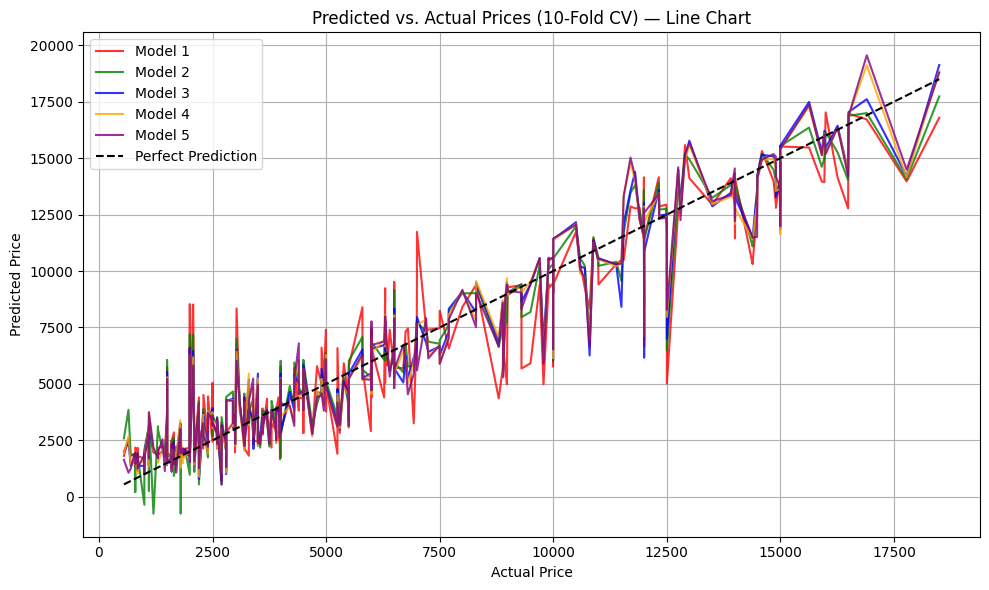

In [92]:
results = []
kf1 = KFold(n_splits=k_fold, shuffle=True, random_state=42)

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((np.array(actuals), np.array(preds)))

# Sort by actual price to align line charts
sorted_indices = np.argsort(results[0][0])  # use actuals from model 1 for consistent sorting
sorted_actual = results[0][0][sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, (actual, pred) in enumerate(results):
    sorted_pred = pred[sorted_indices]
    plt.plot(sorted_actual, sorted_pred, label=f'Model {i+1}', color=colors[i], alpha=0.8)

# Perfect prediction line
plt.plot(sorted_actual, sorted_actual, 'k--', label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (10-Fold CV) — Line Chart")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

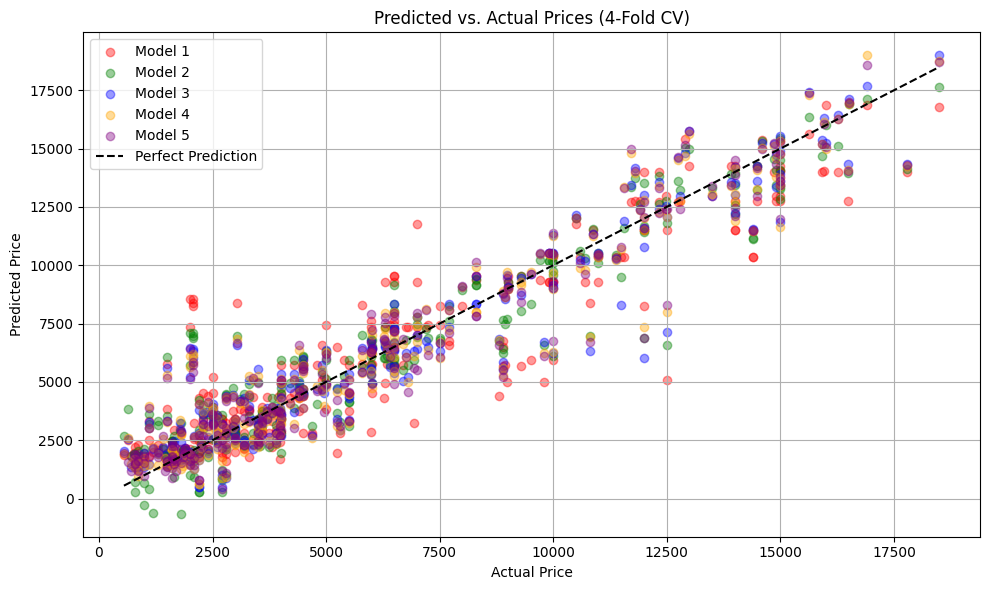

In [93]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
results = []

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((actuals, preds))

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, (actual, pred) in enumerate(results):
    plt.scatter(actual, pred, alpha=0.4, label=f'Model {i+1}', color=colors[i])

plt.plot(
    [data['price'].min(), data['price'].max()],
    [data['price'].min(), data['price'].max()],
    'k--', label='Perfect Prediction'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (4-Fold CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prediction

In [94]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [95]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [96]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [97]:
pd.concat([new, new], ignore_index=True)

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0
1,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [98]:
reg1 = regs[0]
reg3 = regs[2]

In [99]:
reg1.resid.describe()


count    2.810000e+02
mean     1.076117e-10
std      1.758313e+03
min     -6.367827e+03
25%     -8.636628e+02
50%     -1.013318e+02
75%      8.936205e+02
max      7.448668e+03
dtype: float64

In [100]:
(reg3.fittedvalues - data.price).describe()


count    2.810000e+02
mean     5.626568e-11
std      1.325029e+03
min     -5.782218e+03
25%     -5.845089e+02
50%      1.056349e+01
75%      6.282881e+02
max      4.245894e+03
dtype: float64

### Table 13.3 Point predictions and interval predictions for a specific car, using models 1 and 3

Use custom function `point_predict_with_conf_int` to extract point and interval prediction for a new datapoint.

In [101]:
help(point_predict_with_conf_int)

NameError: name 'point_predict_with_conf_int' is not defined

In [ ]:
p95 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.95, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.95, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p95.loc["Prediction Interval (95%)", :] = p95.loc["Prediction Interval (95%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.8, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.8, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p80.loc["Prediction Interval (80%)", :] = p80.loc["Prediction Interval (80%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80.append(p95.loc["Prediction Interval (95%)"])